In [1]:
import astropy.coordinates as coord
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib as mlp
import pandas as pd
import numpy as np

from matplotlib.colors import Normalize
from astropy import units
from astropy.coordinates import SkyCoord
from matplotlib.patches import Polygon
import matplotlib.ticker as ticker


In [24]:
class FormatScalarFormatter(ticker.ScalarFormatter):
    def __init__(self, fformat="%1.1f", offset=True, mathText=True):
        self.fformat = fformat
        ticker.ScalarFormatter.__init__(self,useOffset=offset,
                                                        useMathText=mathText)
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % ticker._mathdefault(self.format)

In [5]:
fname = 'ztf_field_corners.csv'
data = pd.read_csv(fname)

data_masha = pd.read_csv('fields_20220721.csv')

field_stats = pd.read_csv('stat_fields.txt', header=None, delim_whitespace=True,
                         names=['file', 'n'])

In [6]:
# make column with field ID
field_stats['FID'] = [int(field_stats.iloc[i]['file'][field_stats['file'].values[i].index('_') + 1:
                           field_stats['file'].values[i].index('.')]) 
                     for i in range(field_stats.shape[0])]

In [7]:
mask1 = np.array([item in data_masha['FID'].values for item in data['field'].values])
mask2 = np.array([item in data_masha['FID'].values for item in field_stats['FID'].values])

coord_corners = data[mask1]
coord_corners = coord_corners.reset_index(drop=True)

# add field ID to data frame
n = []
for obj in coord_corners['field'].values:
    mask_field = field_stats['FID'].values == obj
    n.append(field_stats[mask_field]['n'].values[0])
    
coord_corners['n'] = n

In [8]:
names = ['l1', 'b1', 'l2', 'b2', 'l3', 'b3', 'l4', 'b4']

data_lb = []
c = 30

for j in range(coord_corners.shape[0]):
    
    line = []

    for i in range(1,5):

        f1 = SkyCoord((coord_corners.iloc[j]['ra' + str(i)] + c) * units.degree , 
                      coord_corners.iloc[j]['dec' + str(i)] * units.degree, 
                      unit='degree', frame = 'icrs')
        l1 = -f1.ra.wrap_at(180 * units.deg).radian
        b1 = f1.dec.radian
        line.append(l1)
        line.append(b1)

    data_lb.append(line)
    
df = pd.DataFrame(data_lb, columns=names)

coord_corners = pd.concat([coord_corners, df], axis=1)

In [9]:
min(field_stats[field_stats['n'] > 0]['n'])

3514

In [10]:
max(field_stats[field_stats['n'] > 0]['n'])

9486393

(array([105.,  28.,  13.,   7.,   8.,   6.,   3.,   2.,   5.,   5.]),
 array([3.5140000e+03, 9.5180190e+05, 1.9000898e+06, 2.8483777e+06,
        3.7966656e+06, 4.7449535e+06, 5.6932414e+06, 6.6415293e+06,
        7.5898172e+06, 8.5381051e+06, 9.4863930e+06]),
 <a list of 10 Patch objects>)

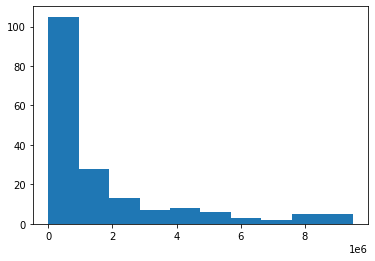

In [11]:
plt.hist(field_stats[field_stats['n'] > 0]['n'])

In [16]:
# set up color 135
cvals  = [3000, 1500000]
norm = Normalize(min(cvals),max(cvals))
cmap = cm.get_cmap('Spectral')

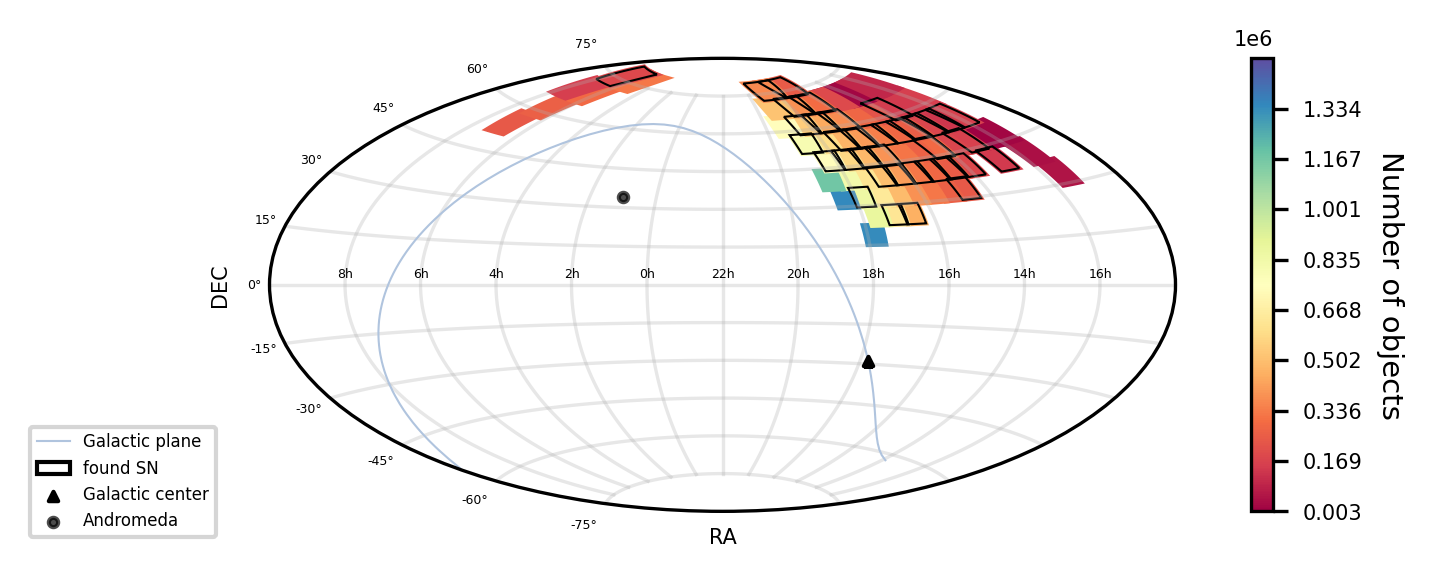

In [30]:
fig = plt.figure(figsize=(5,2), dpi=300)

ax = fig.add_subplot(111, projection='aitoff')

for j in range(1, coord_corners.shape[0]):
    y = np.array([[coord_corners.iloc[j]['l1'],coord_corners.iloc[j]['b1']], 
                  [coord_corners.iloc[j]['l2'],coord_corners.iloc[j]['b2']], 
                  [coord_corners.iloc[j]['l3'],coord_corners.iloc[j]['b3']], 
                  [coord_corners.iloc[j]['l4'],coord_corners.iloc[j]['b4']]])

    rgb = cmap(norm(coord_corners.iloc[j]['n']))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = mlp.colors.rgb2hex(rgb)
    p = Polygon(y, color=color, alpha=1, zorder=-1)
    ax.add_patch(p)
    
    if data_masha.iloc[j]['SN']:
        p1 = Polygon(y, color='black', fill=None, alpha=1, zorder=1, linewidth=0.5)
        ax.add_patch(p1)
    
# change ticks labels'
ax.set_xticklabels(['8h', '6h', '4h', '2h', '0h', '22h', '20h', '18h', '16h', '14h', '16h'])


# add legend
pl1 = Polygon([[None,None],[None,None],[None,None],[None,None]], 
              fill=None, alpha =1, color='black', label='found SN')
ax.add_patch(pl1)

# add galactic plane
g_p = SkyCoord(l=np.linspace(-50, 296.976, 100)*units.degree, 
               b=np.zeros(100)*units.degree, frame = 'galactic')
plt.plot(-g_p.icrs.ra.wrap_at(180*units.deg).radian-(c*np.pi/180), 
         g_p.icrs.dec.radian, linestyle='-', 
         linewidth = 0.5, color = 'lightsteelblue', label = 'Galactic plane')

# add galactic center
gc = SkyCoord(l=0*units.degree, b=0*units.degree, frame='galactic')
im_c = plt.scatter(-gc.icrs.ra.wrap_at(180 * units.deg).radian-(c*np.pi/180), 
                   gc.icrs.dec.radian, cmap='PuBu', s=5 ,marker='^',
                   edgecolor=None, zorder=5, color='black', label='Galactic center')

# add M31
m31 = SkyCoord(l=(121.174329 + c)*units.degree, 
               b=(-21.573309)*units.degree, frame='galactic')
im_m = plt.scatter(-m31.icrs.ra.wrap_at(180 * units.deg).radian, 
                   m31.icrs.dec.radian, cmap='PuBu', s=5,
                   edgecolor=None, zorder=5, color = 'black', label='Andromeda', 
                   alpha =0.7)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ticks = [round(item) for item in  np.linspace(cvals[0], cvals[1] + 10,10)]
fmt = FormatScalarFormatter("%.1f")
fmt._set_format(vmin=min(ticks), vmax=max(ticks))
cbar = plt.colorbar(sm, ticks=ticks, format=fmt._set_format(vmin=min(ticks), vmax=max(ticks)),
             #boundaries=np.arange(cvals[0], cvals[1], (cvals[1]-cvals[0])/11)
                   )
cbar.set_label("Number of objects", fontsize = 7,rotation=270,labelpad=10)
#cbar.formatter.set_scientific(True)
#cbar.formatter.set_powerlimits((0, 0))
cbar.ax.tick_params(labelsize=5)
cbar.ax.yaxis.get_offset_text().set_fontsize(5)
#cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False, useOffset=True))
#cbar.update_ticks()  

plt.tick_params(axis='both', pad = 100, labelsize=3)
plt.grid(zorder=0.5, alpha=0.3)
plt.xlabel('RA', fontsize = 5)
plt.ylabel('DEC', fontsize = 5)
plt.legend(loc=4, fontsize = 2.5)
plt.legend(bbox_to_anchor=(-0.05, -0.075), loc='lower right', fontsize=4)
plt.subplots_adjust(left=0.0, right=1)
#plt.show()
plt.savefig('fields.pdf')

In [75]:
cbar.ax.tick_params?

Signature: cbar.ax.tick_params(axis='both', **kwargs)
Docstring:
Change the appearance of ticks, tick labels, and gridlines.

Tick properties that are not explicitly set using the keyword
arguments remain unchanged unless *reset* is True.

Parameters
----------
axis : {'x', 'y', 'both'}, default: 'both'
    The axis to which the parameters are applied.
which : {'major', 'minor', 'both'}, default: 'major'
    The group of ticks to which the parameters are applied.
reset : bool, default: False
    Whether to reset the ticks to defaults before updating them.

Other Parameters
----------------
direction : {'in', 'out', 'inout'}
    Puts ticks inside the axes, outside the axes, or both.
length : float
    Tick length in points.
width : float
    Tick width in points.
color : color
    Tick color.
pad : float
    Distance in points between tick and label.
labelsize : float or str
    Tick label font size in points or as a string (e.g., 'large').
labelcolor : color
    Tick label color.
color

In [64]:
import matplotlib

In [65]:
matplotlib.__version__

'3.5.2'